# Regression Model for Structural Strength Prediction

## Setup environment

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import sklearn.preprocessing as preprocessing
import statsmodels.api as sm

## Loading data

In [2]:
full_train_data = pd.read_csv("datasets/MaterialStrength_Train.csv")
final_validation_data = pd.read_csv("datasets/MaterialStrength_test.csv")
full_train_data.rename(columns={"fine_aggregate ": "fine_aggregate"}, inplace=True)

## Utility functions

In [3]:
def get_best_fit(A, b, print_params = False):
    AtA = np.matmul(A.transpose(), A)
    Atb = np.matmul(A.transpose(), b)
    x = np.matmul(np.linalg.inv(AtA), Atb)
    if print_params:
        # print(np.c_[A.columns, x])
        pass
    return x

In [4]:
def predict(model_params, attributes):
    predicted_value = np.matmul(attributes, model_params)
    return predicted_value

In [5]:
def mse(predicted_value, actual_value):
    e = actual_value - predicted_value
    return np.matmul(e.transpose(), e) / actual_value.size

In [6]:
def r2Error(predicted_value, actual_value):
    n = actual_value.size
    mserror = mse(predicted_value, actual_value)
    mean_y = np.sum(actual_value)/n
    tss = np.dot(actual_value - mean_y, actual_value - mean_y)
    r2 = 1 - (mserror * n/tss)
    return r2

In [7]:
def train_test_df(train_data, test_data):
    # Separate attribute and value
    actual_train_value = train_data["Material Strength"]
    train_attributes = train_data.drop("Material Strength", axis=1)

    actual_test_value = test_data["Material Strength"]
    test_attributes = test_data.drop("Material Strength", axis=1)

    # Train the model with train data
    model_params = get_best_fit(train_attributes, actual_train_value)

    # Get predicted values
    predicted_train_value = predict(model_params, train_attributes)
    predicted_test_value = predict(model_params, test_attributes)

    # Get its score for train and test data
    errors = [
        [
            mse(predicted_train_value, actual_train_value),
            mse(predicted_test_value, actual_test_value)
        ], 
        [
            r2Error(predicted_train_value, actual_train_value),
            r2Error(predicted_test_value, actual_test_value)
        ]]
    return pd.DataFrame(errors, columns = ['Train', 'Test'], index = ['MSE', 'R2 Score'])

In [8]:
def split_train_test_df(df):
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=4155)
    return train_test_df(train_data, test_data)

In [9]:
IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return path

## Testing
### Simple expample
Let us test the function get_best_fit using the question from HW1

In [10]:
A = np.array([[1, 0], [1, 1], [1, 3], [1, 4]], dtype=np.float64)
b = np.array([0, 8, 8, 20], dtype=np.float64)
params = get_best_fit(A, b)
p = predict(params, A)
print(p)
e = mse(p, b)
print(e)

[ 1.  5. 13. 17.]
10.999999999999998


## Exploratory data analysis (EDA)
### Original data

In [11]:
split_train_test_df(full_train_data)

,Train,Test
MSE,117.608570,128.800653
R2 Score,0.610944,0.622929


### Removing duplicates

In [12]:
no_duplicates = full_train_data.copy()
no_duplicates.drop_duplicates(inplace=True)
split_train_test_df(no_duplicates)

,Train,Test
MSE,116.445183,117.593693
R2 Score,0.598787,0.620492


### Histograms

PosixPath('images/attribute_histograms.png')

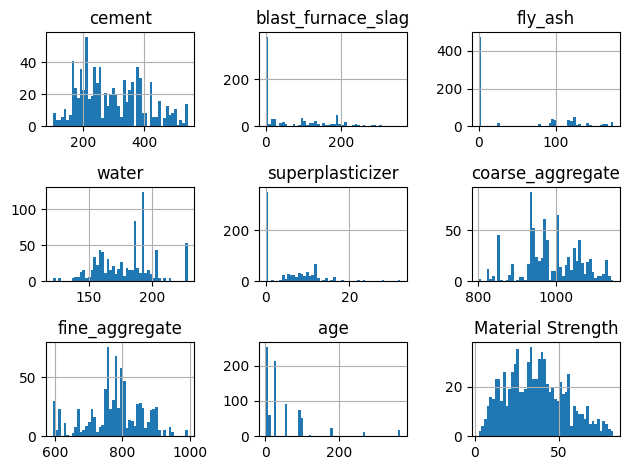

In [13]:
full_train_data.hist(bins=50)
# df = full_train_data["sum"]
save_fig("attribute_histograms")
# plt.show()

- In the results we can see that most of the values associated with the fly_ash,
  blast_furnace_slag and superplasticizer are zero.

### Min Max of attributes

In [14]:
pd.DataFrame(np.c_[ 
             [np.min(full_train_data[attr]) for attr in full_train_data.columns], 
             [np.max(full_train_data[attr]) for attr in full_train_data.columns]],
             index = full_train_data.columns,
             columns = ['Min', 'Max']
            )

,Min,Max
cement,102.00,540.0
blast_furnace_slag,0.00,359.4
fly_ash,0.00,174.7
water,121.80,228.0
superplasticizer,0.00,32.2
coarse_aggregate,801.00,1145.0
fine_aggregate,594.00,992.6
age,1.00,365.0
Material Strength,2.33,82.6


In [15]:
full_train_data.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,Material Strength
count,800.000000,800.000000,800.00000,800.00000,800.000000,800.000000,800.000000,800.00000,800.000000
mean,292.533625,67.819125,47.81125,179.77925,5.693500,985.551875,778.426250,49.69625,36.654187
std,103.719988,86.017377,61.53907,22.18845,6.264438,72.783248,82.670454,69.13960,17.623053
min,102.000000,0.000000,0.00000,121.80000,0.000000,801.000000,594.000000,1.00000,2.330000
25%,212.100000,0.000000,0.00000,162.00000,0.000000,938.000000,746.600000,7.00000,23.242500
50%,277.050000,19.000000,0.00000,184.00000,5.250000,974.000000,780.650000,28.00000,35.340000
75%,374.000000,129.800000,117.50000,192.00000,10.200000,1046.925000,839.525000,56.00000,48.880000
max,540.000000,359.400000,174.70000,228.00000,32.200000,1145.000000,992.600000,365.00000,82.600000


### Log of age
- We have really low readings for higher values of age, superplasticizer,
  fly_ash and blast_fernace_slag, but we have some zero values for everything
  except age so let us try taking its log.

In [58]:
def replace_log(in_df, attrs = ["age"]):
    out_df = in_df.copy()
    for attr in attrs:
        out_df[attr] = np.log(out_df[attr].replace(0, np.nan))
        out_df[attr] = out_df[attr].replace(np.nan, 0)
    return out_df

In [59]:
print(split_train_test_df(no_duplicates))
log_age_df = replace_log(no_duplicates, attrs=["age"])
split_train_test_df(log_age_df)

               Train        Test
MSE       116.445183  117.593693
R2 Score    0.598787    0.620492


,Train,Test
MSE,48.194823,51.078678
R2 Score,0.833944,0.835155


In [61]:
print(split_train_test_df(no_duplicates))
log_age_sp_df = replace_log(no_duplicates, attrs=["age", "superplasticizer"])
split_train_test_df(log_age_df)

               Train        Test
MSE       116.445183  117.593693
R2 Score    0.598787    0.620492


,Train,Test
MSE,45.832337,48.008739
R2 Score,0.842084,0.845062


- Let us compare the box plot of the two

PosixPath('images/box_plot_age.png')

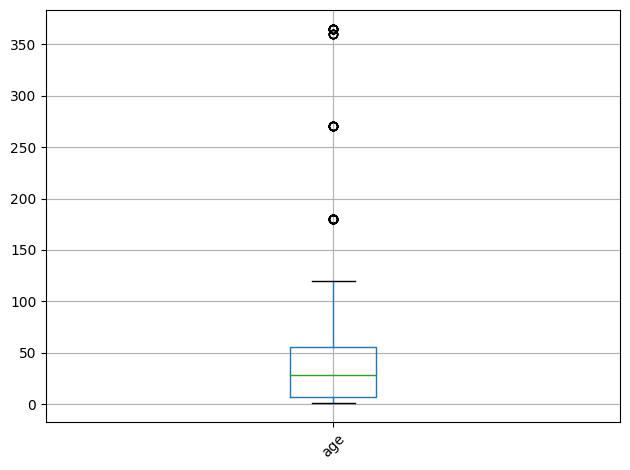

In [62]:
pd.DataFrame(no_duplicates["age"]).boxplot()
plt.xticks(rotation=45)
# plt.show()
save_fig("box_plot_age")

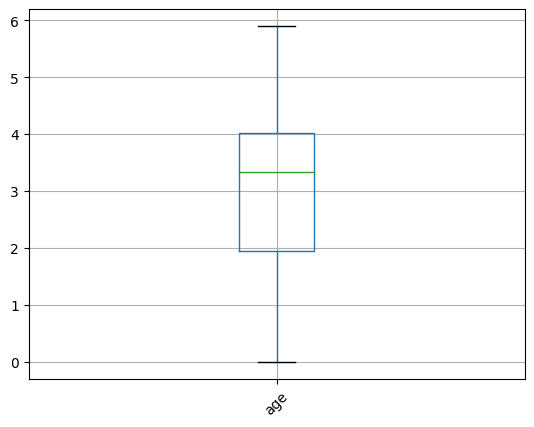

In [64]:
pd.DataFrame(log_age_df["age"]).boxplot()
plt.xticks(rotation=45)
plt.show()
# save_fig("box_plot_log_age")

- Clearly taking log has totally removed the outliers and significently reduced the MSE so we will keep it.

### Outliers
- Let us make box plots to get idea of outliers

PosixPath('images/box_plot.png')

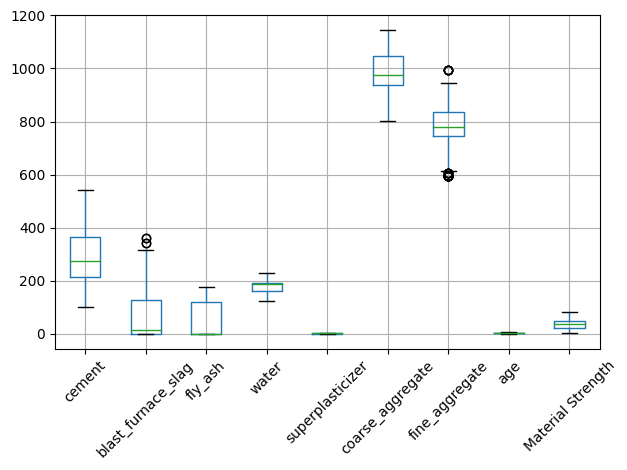

In [20]:
log_superplasticizer_df.boxplot()
plt.xticks(rotation=45)
# plt.show()
save_fig("box_plot")

In [21]:
log_age_df = scale_bfs_df

In [22]:
q1 = log_age_df.quantile(q=0.25, axis=0)
q3 = log_age_df.quantile(q=0.75, axis=0)
iqr = q3 - q1
min_value = q1 - 1.5*iqr
max_value = q3 + 1.5*iqr
count = 0
print(log_age_df.shape)
for i, r in log_age_df.iterrows():
    for attr in full_train_data.columns:
        if r[attr] > max_value[attr] or r[attr] < min_value[attr]:
            # print(i, attr, r[attr])
            count += 1
            break
print(count)
clean_data =  log_age_df[~((log_age_df > max_value)|(log_age_df < min_value)).any(axis=1)]
split_train_test_df(clean_data)

(776, 9)
44


,Train,Test
MSE,41.084001,43.748756
R2 Score,0.867110,0.851320


In [22]:
clean_data = log_age_df.copy()

### Coorelation
- As our set of features is small, we can not remove features because of high
 internal correlation, so we will focus on the correlation with the Material
 Strength

In [23]:
original_corr_coeff = clean_data.corr()["Material Strength"]
original_corr_coeff

cement                0.459609
blast_furnace_slag    0.094732
fly_ash               0.030219
water                -0.313019
superplasticizer      0.436523
coarse_aggregate     -0.189999
fine_aggregate       -0.239768
age                   0.625581
Material Strength     1.000000
Name: Material Strength, dtype: float64

### Combining attributes

- Let us make all the combinations.

In [50]:
def combine(in_df, attrs = []):
    combination_df = in_df.copy()
    if not attrs:
        attrs = [attr for attr in in_df.columns if attr != "Material Strength"]
    for i in range(len(attrs)):
        for j in range(i, len(attrs)):
            combination_df[attrs[i]+"_x_"+attrs[j]] = combination_df[attrs[i]] * combination_df[attrs[j]]
    combination_corr_coeff = combination_df.corr()["Material Strength"]
    return combination_df
split_train_test_df(combine(clean_data, attrs=["cement", "superplasticizer", "age", "water", "fine_aggregate"]))

,Train,Test
MSE,32.275828,31.479128
R2 Score,0.895601,0.893019


In [51]:
all_combination_df = combine(clean_data)
split_train_test_df(all_combination_df)

,Train,Test
MSE,23.674808,27.110485
R2 Score,0.923422,0.907865


- The MSE on the training data has reduced by a lot, but for the validation
  data, it is still much higher then the training data, this is a case of
  overfitting.
- Also this has added lot of attributes, some of which will be useless, so let
  us be specific and select which features we want to combine.
- Here we can observe that cement, superplasticizer and age have high absolute
  coorelation, so we can try combining only these attribute.

- We can try things by manually, but we will not find the optimal parameters, so
  let us try using forward selection to select a few good attributes

In [70]:
def forward_select(in_df, select_num = 10, selected_attrs = []):
    attrs = [attr for attr in in_df.columns if attr != "Material Strength"]
    select_num = min(select_num, len(attrs) - len(selected_attrs))
    for _ in range(select_num):
        min_round_error = float("inf")
        best_attr = ""
        for attr in [att for att in attrs if att not in selected_attrs]:
            curr_attrs = selected_attrs + [attr, "Material Strength"]
            errors = split_train_test_df(in_df[curr_attrs])
            MSE = errors['Test']['MSE'] + errors['Train']['MSE'] + (errors['Test']['MSE'] - errors['Train']['MSE'])**2
            if min_round_error > MSE:
                min_round_error = MSE
                best_attr = attr
        selected_attrs.append(best_attr)
        print(split_train_test_df(in_df[selected_attrs + ["Material Strength"]]))
    # print(selected_attrs)
    return selected_attrs

In [71]:
forward_select(all_combination_df, select_num=34, selected_attrs = ["cement", "superplasticizer", "age", "water", "fine_aggregate"])

              Train       Test
MSE       40.282396  44.438654
R2 Score   0.869703   0.848976
              Train       Test
MSE       37.317070  37.624104
R2 Score   0.879295   0.872135
              Train       Test
MSE       36.194127  35.888599
R2 Score   0.882927   0.878033
              Train       Test
MSE       34.819906  35.147130
R2 Score   0.887372   0.880553
              Train       Test
MSE       34.413837  33.844075
R2 Score   0.888686   0.884981
              Train       Test
MSE       33.920615  33.291921
R2 Score   0.890281   0.886858
              Train       Test
MSE       33.252092  32.230651
R2 Score   0.892443   0.890465
              Train       Test
MSE       32.754321  31.856322
R2 Score   0.894053   0.891737
              Train       Test
MSE       32.482262  31.664145
R2 Score   0.894933   0.892390
              Train       Test
MSE       32.271577  31.725465
R2 Score   0.895615   0.892181
              Train       Test
MSE       31.868036  30.936076
R2 Score

['cement',
 'superplasticizer',
 'age',
 'water',
 'fine_aggregate',
 'blast_furnace_slag_x_age',
 'fly_ash_x_age',
 'fine_aggregate_x_age',
 'superplasticizer_x_age',
 'cement_x_superplasticizer',
 'blast_furnace_slag_x_fine_aggregate',
 'water_x_water',
 'superplasticizer_x_fine_aggregate',
 'fly_ash_x_fine_aggregate',
 'superplasticizer_x_coarse_aggregate',
 'age_x_age',
 'fly_ash_x_superplasticizer',
 'cement_x_water',
 'fly_ash_x_coarse_aggregate',
 'blast_furnace_slag_x_blast_furnace_slag',
 'fly_ash_x_fly_ash',
 'water_x_coarse_aggregate',
 'blast_furnace_slag_x_superplasticizer',
 'blast_furnace_slag_x_coarse_aggregate',
 'blast_furnace_slag_x_water',
 'fly_ash',
 'blast_furnace_slag_x_fly_ash',
 'cement_x_fine_aggregate',
 'cement_x_fly_ash',
 'coarse_aggregate_x_age',
 'superplasticizer_x_superplasticizer',
 'cement_x_blast_furnace_slag',
 'water_x_age',
 'coarse_aggregate_x_coarse_aggregate',
 'cement_x_cement',
 'coarse_aggregate_x_fine_aggregate',
 'fly_ash_x_water',
 'cem

### Multiply everything

In [38]:
print(split_train_test_df(combination_df))
tp = all_combination_df.copy()
attr = [ "cement", "age", "fine_aggregate", "coarse_aggregate", "water", "superplasticizer"]
tp['a'] = full_train_data["age"]* full_train_data["fine_aggregate"]* full_train_data["superplasticizer"]* full_train_data["cement"]
split_train_test_df(tp)
all_combination_df = tp

              Train       Test
MSE       32.275828  31.479128
R2 Score   0.895601   0.893019


### Per unit of cement

- Intutively I think that the amount of certain component with respect to
other component can have high importance, and as cement is one of the main
component, and there are no zeros for this feature so we should try to add
the parameters divided by amount of cement.

In [42]:
per_unit_df = all_combination_df.copy()
new_per_unit_attrs = [attr for attr in full_train_data.columns if attr not in ["Material Strength", "cement", "age"]]
for attr in new_per_unit_attrs:
    per_unit_df[attr+"_per_unit_cement"] = per_unit_df[attr] / per_unit_df["cement"]

all_combination_df = per_unit_df
split_train_test_df(per_unit_df)

,Train,Test
MSE,21.789586,22.241530
R2 Score,0.929520,0.924412


- There appears to be some amount of overfitting
- Let us analyze the change in the absolute value of corr of different
  attributes due to this division.

In [27]:
per_unit_corr_coeff = per_unit_df.corr()["Material Strength"]
pd.DataFrame(np.c_[new_per_unit_attrs, 
[abs(per_unit_corr_coeff[attr+'_per_unit_cement']) - abs(original_corr_coeff[attr]) for attr in new_per_unit_attrs]])

,0,1
0,blast_furnace_slag,-0.0024650283035928117
1,fly_ash,-0.000407979363480665
2,water,0.14942046175826096
3,superplasticizer,-0.18397978609442778
4,coarse_aggregate,0.23965116965555835
5,fine_aggregate,0.19227345292721626


- We can see a high positive change for water, {fly_ash}?, coarse_aggregate,
  fine_aggregate, let us try to add only these values.

In [28]:
per_unit_df = clean_data.copy()
new_per_unit_attrs = [ "water", "fine_aggregate", "coarse_aggregate"]
for attr in new_per_unit_attrs:
    per_unit_df[attr+"_per_unit_cement"] = per_unit_df[attr] / per_unit_df["cement"]

split_train_test_df(per_unit_df)

,Train,Test
MSE,39.232851,42.307839
R2 Score,0.873098,0.856217


- Still high overfitting

- Let us try to use this with the multiplication features

In [29]:
per_unit_df = combination_df.copy()
new_per_unit_attrs = [ "water", "fine_aggregate", "coarse_aggregate"]
for attr in new_per_unit_attrs:
    per_unit_df[attr+"_per_unit_cement"] = per_unit_df[attr] / per_unit_df["cement"]

split_train_test_df(per_unit_df)

,Train,Test
MSE,31.316363,30.098261
R2 Score,0.898705,0.897711


- This does not give vary good results with multiplication features so let us
  drop this for now.

### Bias

- Let us try adding a bias.

In [30]:
# print(split_train_test_df(combination_df))

bias_df = combination_df.copy()
bias_df["bias"] = 1

# print(split_train_test_df(bias_df))
tp_df = bias_df.copy()
for attr in tp_df.columns:
    if attr != "Material Strength":
        tp_df[attr] /= np.max(tp_df[attr])

split_train_test_df(tp_df)

,Train,Test
MSE,29.893701,28.608861
R2 Score,0.903306,0.902773


### Thickness
- Amount of solid divided by amount of liquid

In [31]:
thickness_df = bias_df.copy()
print(full_train_data.columns)
thickness_df["thickness"] = (thickness_df["cement"] + thickness_df["coarse_aggregate"] + thickness_df["fly_ash"] + thickness_df["fine_aggregate"]) / (thickness_df["water"] + thickness_df["superplasticizer"])
print(thickness_df.corr()["Material Strength"]["thickness"])
split_train_test_df(thickness_df)

Index(['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate', 'age', 'Material Strength'],
      dtype='object')
0.30665728314456775


,Train,Test
MSE,29.862831,28.411977
R2 Score,0.903406,0.903442


### Scatter plot

PosixPath('images/scatter.png')

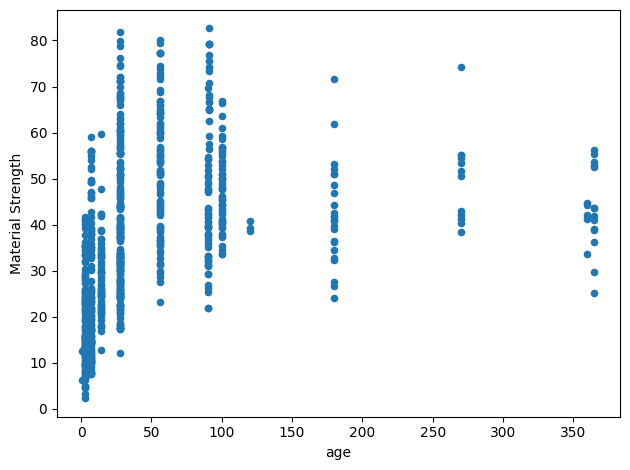

In [32]:
full_train_data.plot.scatter("age", "Material Strength")
save_fig("scatter")

## Statical Analysis using OLS

In [57]:
def ols_df(df, k = 5, add_bias = False):
    data = df.copy()
    if add_bias:
        data['bias'] = 1
    x = data.drop("Material Strength", axis=1)
    y = data["Material Strength"]
    return sm.OLS(y, x).fit()

In [61]:
ols_df(full_train_data.drop("coarse_aggregate", axis=1), add_bias=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Material Strength   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     180.7
Date:                Mon, 04 Sep 2023   Prob (F-statistic):          2.16e-159
Time:                        02:13:12   Log-Likelihood:                -3048.3
No. Observations:                 800   AIC:                             6113.
Df Residuals:                     792   BIC:                             6150.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
cement                 0.0928      0.007     13.621      0.000       0.079       0.106
blast_furnace_slag     0.0756      0.008      9.937      0.000       0.061       0.091
fly_ash                0.0689      0.012      5.990      0.000       0.046       0.092
water                 -0.2250      0.032     -7.040      0.000      -0.288      -0.162
superplasticizer       0.3843      0.118      3.247      0.001       0.152       0.617
fine_aggregate        -0.0098      0.007     -1.328      0.184      -0.024       0.005
age                    0.1177      0.006     19.402      0.000       0.106       0.130
bias                  41.1392     11.024      3.732      0.000      19.499      62.779
==============================================================================
Omnibus:                        4.204   Durbin-Watson:                   1.278
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                4.256
Skew:                          -0.176   Prob(JB):                        0.119
Kurtosis:                       2.939   Cond. No.                     2.44e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
ols_df(combination_df, add_bias=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Material Strength   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     290.3
Date:                Mon, 04 Sep 2023   Prob (F-statistic):               0.00
Time:                        02:20:56   Log-Likelihood:                -2275.6
No. Observations:                 732   AIC:                             4599.
Df Residuals:                     708   BIC:                             4709.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
cement                                  0.6997      0.062     11.308      0.000       0.578       0.821
blast_furnace_slag                      0.0876      0.008     11.106      0.000       0.072       0.103
fly_ash                                 0.0362      0.011      3.326      0.001       0.015       0.058
water                                   1.7027      0.451      3.775      0.000       0.817       2.588
superplasticizer                       44.0602      8.480      5.196      0.000      27.411      60.709
coarse_aggregate                       -0.0093      0.007     -1.320      0.187      -0.023       0.005
fine_aggregate                          0.8829      0.114      7.755      0.000       0.659       1.106
age                                    29.0391      4.054      7.164      0.000      21.080      36.998
cement_x_cement                     -6.613e-05   2.37e-05     -2.787      0.005      -0.000   -1.95e-05
cement_x_superplasticizer              -0.0315      0.004     -8.779      0.000      -0.039      -0.024
cement_x_age                           -0.0052      0.002     -3.101      0.002      -0.009      -0.002
cement_x_water                         -0.0016      0.000     -9.279      0.000      -0.002      -0.001
cement_x_fine_aggregate                -0.0003   4.14e-05     -6.693      0.000      -0.000      -0.000
superplasticizer_x_superplasticizer    -1.5534      0.632     -2.457      0.014      -2.795      -0.312
superplasticizer_x_age                  0.9713      0.238      4.081      0.000       0.504       1.438
superplasticizer_x_water               -0.0404      0.031     -1.300      0.194      -0.101       0.021
superplasticizer_x_fine_aggregate      -0.0305      0.005     -6.379      0.000      -0.040      -0.021
age_x_age                              -0.5025      0.129     -3.906      0.000      -0.755      -0.250
age_x_water                            -0.0150      0.014     -1.067      0.286      -0.043       0.013
age_x_fine_aggregate                   -0.0179      0.002     -7.175      0.000      -0.023      -0.013
water_x_water                           0.0007      0.001      0.918      0.359      -0.001       0.002
water_x_fine_aggregate                 -0.0020      0.000     -6.417      0.000      -0.003      -0.001
fine_aggregate_x_fine_aggregate        -0.0002   4.27e-05     -5.286      0.000      -0.000      -0.000
bias                                 -640.0203     83.789     -7.638      0.000    -804.525    -475.516
==============================================================================
Omnibus:                       54.688   Durbin-Watson:                   1.478
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.629
Skew:                           0.234 

In [68]:
ols_df(combination_df, add_bias=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Material Strength   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     290.3
Date:                Mon, 04 Sep 2023   Prob (F-statistic):               0.00
Time:                        02:21:28   Log-Likelihood:                -2275.6
No. Observations:                 732   AIC:                             4599.
Df Residuals:                     708   BIC:                             4709.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
cement                                  0.6997      0.062     11.308      0.000       0.578       0.821
blast_furnace_slag                      0.0876      0.008     11.106      0.000       0.072       0.103
fly_ash                                 0.0362      0.011      3.326      0.001       0.015       0.058
water                                   1.7027      0.451      3.775      0.000       0.817       2.588
superplasticizer                       44.0602      8.480      5.196      0.000      27.411      60.709
coarse_aggregate                       -0.0093      0.007     -1.320      0.187      -0.023       0.005
fine_aggregate                          0.8829      0.114      7.755      0.000       0.659       1.106
age                                    29.0391      4.054      7.164      0.000      21.080      36.998
cement_x_cement                     -6.613e-05   2.37e-05     -2.787      0.005      -0.000   -1.95e-05
cement_x_superplasticizer              -0.0315      0.004     -8.779      0.000      -0.039      -0.024
cement_x_age                           -0.0052      0.002     -3.101      0.002      -0.009      -0.002
cement_x_water                         -0.0016      0.000     -9.279      0.000      -0.002      -0.001
cement_x_fine_aggregate                -0.0003   4.14e-05     -6.693      0.000      -0.000      -0.000
superplasticizer_x_superplasticizer    -1.5534      0.632     -2.457      0.014      -2.795      -0.312
superplasticizer_x_age                  0.9713      0.238      4.081      0.000       0.504       1.438
superplasticizer_x_water               -0.0404      0.031     -1.300      0.194      -0.101       0.021
superplasticizer_x_fine_aggregate      -0.0305      0.005     -6.379      0.000      -0.040      -0.021
age_x_age                              -0.5025      0.129     -3.906      0.000      -0.755      -0.250
age_x_water                            -0.0150      0.014     -1.067      0.286      -0.043       0.013
age_x_fine_aggregate                   -0.0179      0.002     -7.175      0.000      -0.023      -0.013
water_x_water                           0.0007      0.001      0.918      0.359      -0.001       0.002
water_x_fine_aggregate                 -0.0020      0.000     -6.417      0.000      -0.003      -0.001
fine_aggregate_x_fine_aggregate        -0.0002   4.27e-05     -5.286      0.000      -0.000      -0.000
bias                                 -640.0203     83.789     -7.638      0.000    -804.525    -475.516
==============================================================================
Omnibus:                       54.688   Durbin-Watson:                   1.478
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.629
Skew:                           0.234 

In [64]:
ols_df(bias_df).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Material Strength   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     290.3
Date:                Mon, 04 Sep 2023   Prob (F-statistic):               0.00
Time:                        02:19:45   Log-Likelihood:                -2275.6
No. Observations:                 732   AIC:                             4599.
Df Residuals:                     708   BIC:                             4709.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
cement                                  0.6997      0.062     11.308      0.000       0.578       0.821
blast_furnace_slag                      0.0876      0.008     11.106      0.000       0.072       0.103
fly_ash                                 0.0362      0.011      3.326      0.001       0.015       0.058
water                                   1.7027      0.451      3.775      0.000       0.817       2.588
superplasticizer                       44.0602      8.480      5.196      0.000      27.411      60.709
coarse_aggregate                       -0.0093      0.007     -1.320      0.187      -0.023       0.005
fine_aggregate                          0.8829      0.114      7.755      0.000       0.659       1.106
age                                    29.0391      4.054      7.164      0.000      21.080      36.998
cement_x_cement                     -6.613e-05   2.37e-05     -2.787      0.005      -0.000   -1.95e-05
cement_x_superplasticizer              -0.0315      0.004     -8.779      0.000      -0.039      -0.024
cement_x_age                           -0.0052      0.002     -3.101      0.002      -0.009      -0.002
cement_x_water                         -0.0016      0.000     -9.279      0.000      -0.002      -0.001
cement_x_fine_aggregate                -0.0003   4.14e-05     -6.693      0.000      -0.000      -0.000
superplasticizer_x_superplasticizer    -1.5534      0.632     -2.457      0.014      -2.795      -0.312
superplasticizer_x_age                  0.9713      0.238      4.081      0.000       0.504       1.438
superplasticizer_x_water               -0.0404      0.031     -1.300      0.194      -0.101       0.021
superplasticizer_x_fine_aggregate      -0.0305      0.005     -6.379      0.000      -0.040      -0.021
age_x_age                              -0.5025      0.129     -3.906      0.000      -0.755      -0.250
age_x_water                            -0.0150      0.014     -1.067      0.286      -0.043       0.013
age_x_fine_aggregate                   -0.0179      0.002     -7.175      0.000      -0.023      -0.013
water_x_water                           0.0007      0.001      0.918      0.359      -0.001       0.002
water_x_fine_aggregate                 -0.0020      0.000     -6.417      0.000      -0.003      -0.001
fine_aggregate_x_fine_aggregate        -0.0002   4.27e-05     -5.286      0.000      -0.000      -0.000
bias                                 -640.0203     83.789     -7.638      0.000    -804.525    -475.516
==============================================================================
Omnibus:                       54.688   Durbin-Watson:                   1.478
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.629
Skew:                           0.234 

## Gradient Descent

In [211]:
def gradient_descent(attrs, act_val, params=[], learning_rate = 0.01, iters = 10):
    n = attrs.shape[1]
    # learning_rate = 0.01
    if not len(params):
      print('random')
      params = np.random.random((attrs.shape[1]))
    for _ in range(iters):
      p = predict(params, attrs)
      e = p - act_val
      loss = np.mean(e**2)
      a = np.tile(e, (n, 1)).transpose()
      grad = (-2/n) * (a*attrs).sum(axis=0)
      # Recalculating the params
      params += learning_rate * grad
      print(e[:5])
      # print(loss)

In [212]:
train_data, test_data = train_test_split(full_train_data, test_size=0.2, random_state=4155)
attrs = train_data.drop("Material Strength", axis=1)
vals = train_data["Material Strength"]
params = get_best_fit(attrs, vals, print_params = False)
gradient_descent(attrs, vals, learning_rate=0.1)

random
511    1140.450761
692    1118.837157
702    1134.312412
472    1109.537057
387    1211.111818
dtype: float64
511   -2.827639e+10
692   -3.000524e+10
702   -3.046873e+10
472   -3.031884e+10
387   -3.024602e+10
dtype: float64
511    7.726865e+17
692    8.201571e+17
702    8.328450e+17
472    8.287198e+17
387    8.263484e+17
dtype: float64
511   -2.112148e+25
692   -2.241914e+25
702   -2.276597e+25
472   -2.265318e+25
387   -2.258831e+25
dtype: float64
511    5.773594e+32
692    6.128311e+32
702    6.223118e+32
472    6.192286e+32
387    6.174553e+32
dtype: float64
511   -1.578222e+40
692   -1.675185e+40
702   -1.701100e+40
472   -1.692672e+40
387   -1.687825e+40
dtype: float64
511    4.314098e+47
692    4.579146e+47
702    4.649987e+47
472    4.626950e+47
387    4.613699e+47
dtype: float64
511   -1.179266e+55
692   -1.251718e+55
702   -1.271082e+55
472   -1.264785e+55
387   -1.261163e+55
dtype: float64
511    3.223545e+62
692    3.421592e+62
702    3.474525e+62
472    3.457311e+6

## KNN

### Defining distance
The formula for the distance plays important role in the output of KNN. Here
we will give higher waitage to parameters with higher coorelation. Also, we
divide the coeff with the maximum value of the given coefficient scale them.

In [33]:
corrs = full_train_data.corr()["Material Strength"]
corrs.drop(["Material Strength"], inplace=True)
max_values = [np.max(full_train_data[attr]) for attr in full_train_data.columns if attr != "Material Strength"]
coeff = corrs / max_values

In [34]:
def distance(p1, p2):
    diff = p2 - p1
    diff *= coeff
    dist = diff.dot(diff)
    return dist

### Utility Functions

In [35]:
def KNN_predict(given_data, new_point, k = 5):
    given_attrs = given_data.drop("Material Strength", axis=1)
    dist = [distance(new_point, row) for _,row in given_attrs.iterrows()]
    all_pts = np.c_[dist, given_data["Material Strength"]]
    all_pts = sorted(all_pts, key=lambda p: p[0])
    tot = 0
    for i in range(k):
        tot += all_pts[i][1]
    return tot/k

In [36]:
def knn_score(train_data, attributes, actual_value, k = 5):
    predicted_value = [KNN_predict(train_data, data_point, k = k) for _,data_point in attributes.iterrows()]

    # Get its score for train and test data
    errors = mse(predicted_value, actual_value), r2Error(predicted_value, actual_value)
    return errors

In [37]:
def test_knn(train_data, test_data, k = 5):
    # Separate attribute and value
    actual_value_train = train_data["Material Strength"]
    attributes_train = train_data.drop("Material Strength", axis=1)
    actual_value_test = test_data["Material Strength"]
    attributes_test = test_data.drop("Material Strength", axis=1)

    # Get its score for train and test data
    # train_score = knn_score(train_data, attributes_train, actual_value_train)
    test_score = knn_score(train_data, attributes_test, actual_value_test, k = k)
    # return train_score, test_score
    return test_score

In [38]:
def split_test_knn(df, k = 5):
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=4155)
    return test_knn(train_data, test_data, k = k)

In [39]:
split_test_knn(full_train_data, k = 4)

(73.241017109375, 0.7855830989609248)

In [40]:
split_test_knn(combination_df, k = 4)

(306.68476951530613, -0.04226376476134597)

Let us try to find the value of k which gives best results.

In [42]:
# for i in range(1, 11):
#     print(i, split_test_knn(full_train_data, k = i))

Finding the problem

In [ ]:
train_data, test_data = train_test_split(full_train_data, test_size=0.2, random_state=4155)
attributes_test = test_data.drop("Material Strength", axis=1)
print(KNN_predict(train_data, attributes_test.iloc[1]))
print(test_data.iloc[1])

### KNN + Linear Regression